In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pyro
import scipy as sp
import scipy.stats
import time
import torch
import yaml
try:
    from yaml import CLoader as Loader
except ImportError:
    from yaml import Loader

In [2]:
# These scenes include uniformly randomly distributed nonpenetrating
# object arrangements
DATA_FILE = "data/20181127_uniform_feasible_1_box_1000/20181127_uniform_feasible_1_box_1000.yaml"
# These loaded scenes include squares on the left half of the scene, and
# long rectangles on the right half of the scene. All objects
# tend to lie along cardinal directions (theta = 0, pi/2, pi, ...)
#DATA_FILE = "data/20180709_sorted_grid_10000.yaml"

with open(DATA_FILE, "r") as f:
    environments = yaml.load(f, Loader=Loader)
    N_ENVIRONMENTS = len(environments.keys())
    print("Loaded %d environments from file %s" % (N_ENVIRONMENTS, DATA_FILE))
environments = [environments[key] for key in environments.keys()]

Loaded 1000 environments from file data/20181127_uniform_feasible_1_box_1000/20181127_uniform_feasible_1_box_1000.yaml


Selection of environments from original distribution


/home/gizatt/miniconda2/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


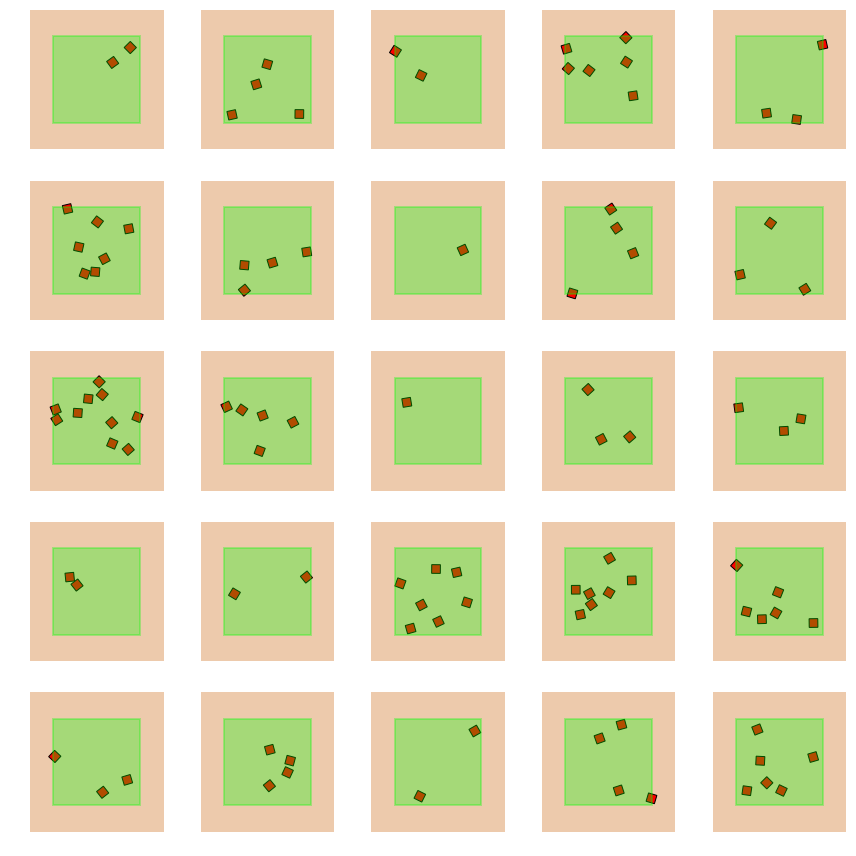

In [3]:
# Illustrate a few example scenes from the training set
import generate_planar_scene_arrangements as psa_utils

def draw_environment(environment, ax):
    rbt, q = psa_utils.build_rbt_from_summary(environment)
    psa_utils.draw_board_state(ax, rbt, q)
    
    patch = patches.Rectangle([0., 0.], 1., 1., fill=True, color=[0., 1., 0.], 
                              linestyle='solid', linewidth=2, alpha=0.3)
    ax.add_patch(patch)

plt.figure().set_size_inches(12, 12)
print "Selection of environments from original distribution"
N = 5
for i in range(N):
    for j in range(N):
        plt.subplot(N, N, i*N+j+1)
        draw_environment(environments[i*N+j], plt.gca())
        plt.grid(True)
plt.tight_layout()

Write our generator in Pyro, as an iterative procedure:

~~~python
keep_going = True
# Spawn the first object with no context -- in our case,
# this is placing a hard-coded ground object.
env = spawn_initial_object()
while (keep_going):
    # Pick an object to spawn
    ci = sample_object_class(env)
    # Pick where to put it
    env = sample_object_placement(ci, env)
    # Make that placement feasible
    env = project_env_to_feasibility(env)
    keep_going = decide_to_continue(env)
~~~

In [21]:
from collections import namedtuple
import torch
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from pyro import poutine
from pyro.contrib.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate
#torch.manual_seed(101);

pyro.enable_validation(True)

object_classes = ["small_box"]
object_class_to_index = {}
for i, obj in enumerate(object_classes):
    object_class_to_index[obj] = i
n_object_classes = len(object_classes)


def sample_object_class(n, generated_data, i, keep_going, obs=None):
    # For now, single object class, so this is trivial.
    # Down the road, the category probs will need to depend on env
    # in some way.
    return pyro.sample(
        "%d_class_assignment" % i, dist.Categorical(torch.Tensor([1.0]).expand([n, 1])).mask(keep_going),
        obs=obs)

# Prior distributions for each object class over the ground
class ObjectWorldPriorDescription:
    def __init__(self, ci):
        # parameterized uniform distribution
        self.bound_center = pyro.sample('c%d_center' % ci, dist.Normal(0.5, 0.5).expand([3]).to_event(1))
        self.bound_halfwidth = pyro.sample('c%d_halfwidth' % ci, dist.LogNormal(0.5, 0.25).expand([3]).to_event(1))

def sample_object_placement(n, ci, generated_data, i, keep_going, object_world_prior_params, obs=None):
    # TODO: figure out how to do a broadcast-select of this.
    # I could use index_select if I stacked the params into a Tensor,
    # I just need to abandon my nice data structure...
    prior_info = object_world_prior_params[0]

    location = pyro.sample('location_%d' % (i),
        #using uniform leads to infinite losses later on, due to
        #some observations having zero support
        #dist.Uniform(prior_info.bound_center - prior_info.bound_halfwidth,
        #             prior_info.bound_center + prior_info.bound_halfwidth),
        dist.Normal(prior_info.bound_center.expand([n, 3]),
                    prior_info.bound_halfwidth.expand([n, 3])).to_event(1).mask(keep_going),
        obs=obs)

    # Fill in generated data appropriately
    generated_data.idents[:, i] = ci.view(-1).type(torch.long)
    generated_data.poses[:, (3*i):(3*i+3)] = torch.Tensor(location).view(-1, 3)
    return generated_data

MAX_NUM_OBJECTS = 10    
def sample_keep_going(n, env, i, falloff_rate, obs=None):
    return pyro.sample('keep_going_%d' % i,
                        dist.Bernoulli((falloff_rate**i).expand(n)),
                        obs=obs)

VectorizedEnvironments = namedtuple("VectorizedEnvironments",
    ["idents", "poses"], verbose=False)
def vectorize_environments(envs):
    # Vectorization into a 
    # poses (order x y theta) and
    # idents (ci) per object
    n_environments = len(envs)
    poses = torch.Tensor(n_environments, MAX_NUM_OBJECTS*3)
    poses[:, :] = 0.
    idents = torch.LongTensor(n_environments, MAX_NUM_OBJECTS)
    idents[:, :] = 0
    for i, env in enumerate(envs):
        for k in range(MAX_NUM_OBJECTS):
            if k < env["n_objects"]:
                obj = env["obj_%04d" % k]
                idents[i, k] = object_class_to_index[obj["class"]]
                poses[i, (k*3):(k*3+3)] = torch.Tensor(obj["pose"])
            else:
                idents[i, k] = 0
    return VectorizedEnvironments(idents=idents, poses=poses)
    
def devectorize_environments(data):
    if not isinstance(data, VectorizedEnvironments):
        raise ValueError("Expected VectorizedEnvironments input")
    envs = []
    for i in range(data.idents.shape[0]):
        env = {}
        n_objects = 0
        for k in range(MAX_NUM_OBJECTS):
            if data.idents[i, k] >= 0:
                obj = {
                    "pose": data.poses[i, (k*3):(k*3+3)].cpu().detach().numpy(),
                    "class": object_classes[data.idents[i, k].cpu().detach().item()]
                }
                env["obj_%04d" % k] = obj
                n_objects += 1
            else:
                break
        env["n_objects"] = n_objects
        envs.append(env)
    return envs

# Each row of "data" is a vectorized
# description of an environment.
# To make these rows constant size, all vectorizations
# are the same length, but padded with "null objects"
# up to a max number of objects. This is inspired by
# the handling of the Pyro AIR example.

def model(data=None):
            
    i = 0
    keep_going = True
    
    object_world_prior_params = []
    for i in range(n_object_classes):
        object_world_prior_params.append(
            ObjectWorldPriorDescription(i)
        )
    falloff_rate = pyro.sample("falloff_rate", dist.Uniform(0.0, 1.0))
    
    # Generate in vectorized form for easier batch conversion at the end
    n = 1
    if data:
        if not isinstance(data, VectorizedEnvironments):
            raise ValueError("Expected VectorizedEnvironments input")
        if (data.idents.shape[1] != MAX_NUM_OBJECTS and
           data.poses.shape[1] != MAX_NUM_OBJECTS*3):
            raise ValueError("Got unexpected data shape.")
        n = data.idents.shape[0]
    with pyro.plate('data', n):
        generated_data = VectorizedEnvironments(
            idents=torch.LongTensor(n, MAX_NUM_OBJECTS),
            poses=torch.Tensor(n, MAX_NUM_OBJECTS*3))
        generated_data.idents[:, :] = -1
        generated_data.poses[:, :] = 0
        for i in range(MAX_NUM_OBJECTS):
            gt_class = None
            gt_location = None
            gt_keep_going = None
            if data is not None:
                gt_class = data.idents[:, i]
                gt_location = data.poses[:, (i*3):(i*3+3)]
                gt_keep_going = data.idents[:, i] != -1
                gt_keep_going = gt_keep_going.type(dtype=torch.float32)
            keep_going = sample_keep_going(n, generated_data, i, falloff_rate, gt_keep_going)
            ci = sample_object_class(n, generated_data, i, keep_going, gt_class)
            generated_data = sample_object_placement(n, ci, generated_data, i, keep_going, object_world_prior_params, gt_location)
            # skip feasibility project for first pass
    return generated_data

for k in range(100):
     model()
print model()

VectorizedEnvironments(idents=tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), poses=tensor([[ 2.6867,  0.8093,  3.4467, -2.1247, -2.5644,  2.7633,  4.7021,  1.0353,
          2.7617,  3.3041,  0.7968,  2.9664,  3.4247, -1.3389,  3.0241, -0.7017,
          0.1711,  2.2675,  4.8122,  2.1605,  2.6694, -0.3062,  1.1271,  1.4384,
          2.3977,  0.9871,  1.7888,  6.6483,  3.1259,  3.7129]]))


Selection of environments from prior / generative model


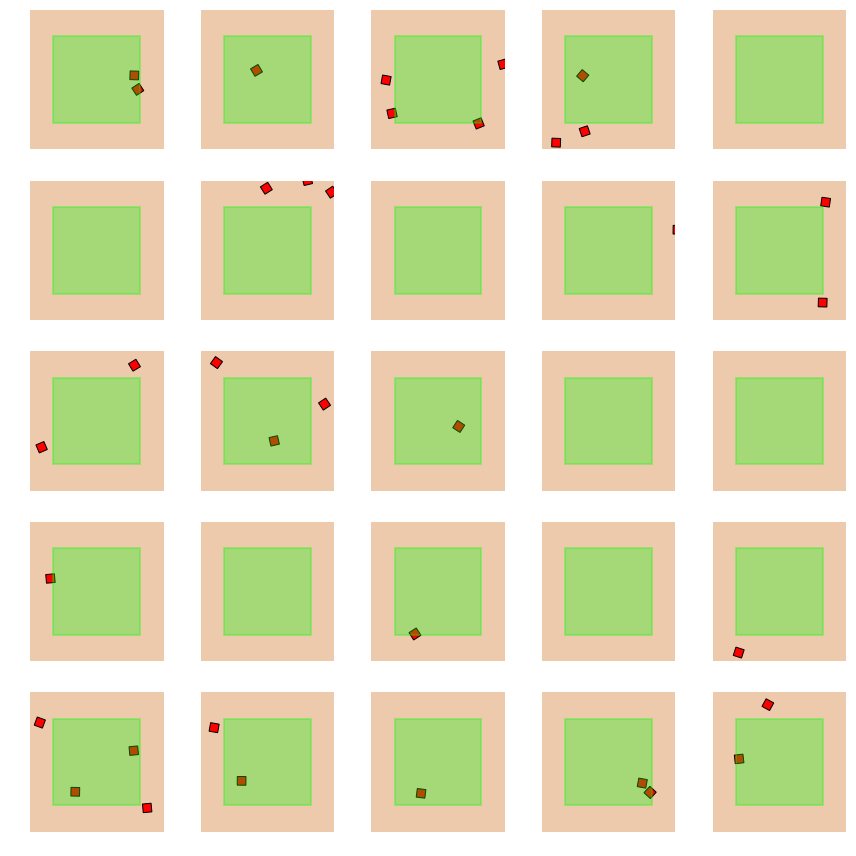

In [11]:
plt.figure().set_size_inches(12, 12)
print "Selection of environments from prior / generative model"
N = 5

for i in range(N):
    for j in range(N):
        plt.subplot(N, N, i*N+j+1)
        draw_environment(devectorize_environments(model())[0], plt.gca())
        plt.grid(True)
plt.tight_layout()

In [28]:
# Rig for SVI.
from collections import defaultdict
from torch.distributions import constraints
from pyro.infer import Trace_ELBO

global_guide = AutoDelta(poutine.block(model, expose=['falloff_rate', 'c0_center', 'c0_halfwidth']))
optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_iarange_nesting=1)
svi = SVI(model, global_guide, optim, loss=elbo)

def initialize(seed):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    pyro.param('auto_falloff_rate', torch.tensor(0.5), constraint=constraints.unit_interval)
    pyro.param('auto_c0_center', torch.Tensor([0.5, 0.5, 1.57]))
    pyro.param('auto_c0_halfwidth', torch.Tensor([0.5, 0.5, 1.57]))

# Choose the best among 100 random initializations.
#initialize(42)

losses = []
data = vectorize_environments(environments)
for i in range(200):
    loss = svi.step(data)
    losses.append(loss)
    if (i % 10 == 0):
        print ".",
print "Done"

. . . . . . . . . . . . . . . . . . . . Done


{'c0_halfwidth': tensor([0.3047, 0.3097, 1.9234], grad_fn=<ExpandBackward>), 'c0_center': tensor([0.1988, 0.2022, 1.2601], grad_fn=<ExpandBackward>), 'falloff_rate': tensor(0.9999, grad_fn=<ExpandBackward>)}


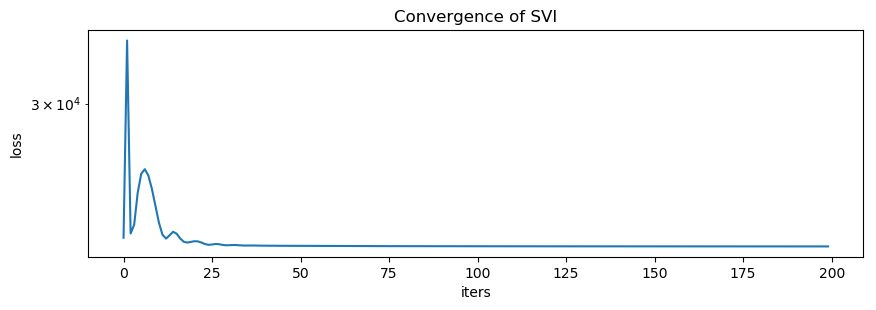

In [29]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI');
print global_guide.median()